In [ ]:
# enabling 3rd party widgets
# from google.colab import output
# output.enable_custom_widget_manager()
# output.disable_custom_widget_manager()

# interactive 3D plot
# !pip install ipympl
# %matplotlib widget

In [61]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg
from scipy.fft import fft, ifft, fftfreq

import time as time
import platform as platform

In [3]:
colab_flag = True

In [4]:
current_sys = platform.system()

if current_sys == 'Windows':
    dir_sep = '\\'
else:
    dir_sep = '/'

In [5]:
if colab_flag == True:
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir('/content/drive/MyDrive/Github/MLROM/KS/')

Mounted at /content/drive


In [6]:
print(os.getcwd())

/content/drive/MyDrive/Github/MLROM/KS


In [7]:
from tools.misc_tools import create_KS_data

In [8]:
# setting seed for PRNGs
prng_seed = 42
np.random.seed(prng_seed)

# KS System

In [50]:
# setting up params (and saving, if applicable)
from numpy import *

# simutlation paramaters
params_mat = np.array([
    [1.0, 1.0, 1.0],
    # [2.0, 1.0, 1.0],
    # [1.0, 2.0, 1.0],
    # [1.0, 1.0, 2.0]
])

t0 = 0.0
T = 220.0
delta_t = 0.1

return_params_arr = False
normalize_flag = False
alldata_withparams_flag = False

numpoints_xgrid = 64
length = 40
xgrid = length*np.linspace(0, 1, numpoints_xgrid)

init_state = np.sin(5*np.pi*xgrid/xgrid[-1])

In [51]:
res_dict = create_KS_data(
    T, t0, delta_t, xgrid,
    init_state, params_mat,
    return_params_arr=return_params_arr,
    normalize=normalize_flag,
    alldata_withparams=alldata_withparams_flag,
)

all_data = res_dict['all_data']
N = res_dict['N']
boundary_idx_arr = res_dict['boundary_idx_arr']
params_arr = res_dict['params_arr']
normalization_constant_arr = res_dict['normalization_constant_arr']

In [52]:
def plot(
        boundary_idx_arr,
        delta_t,
        all_data,
        xgrid,
        xticks_snapto=20,
        num_yticks=11,
    ):

    n = len(boundary_idx_arr)
    # '''
    num_cols = 1
    num_rows = 1
    factor = 1
    # fig = plt.figure(figsize=(7.5*num_cols, 7.5*num_rows))

    num_modes = xgrid.shape[0]

    prev_idx = 0
    for i in range(len(boundary_idx_arr)):
        next_idx = boundary_idx_arr[i]
        fig, ax = plt.subplots(figsize=(factor*7.5*num_cols, factor*5.0*num_rows))
        N = next_idx - prev_idx
        input_time = np.arange(0, N)*delta_t

        im = ax.imshow(all_data[prev_idx:next_idx, 0:num_modes].transpose(), aspect='auto', origin='lower')
        num_xticks = 1 + int((N*delta_t + 0.5*xticks_snapto) // xticks_snapto)
        # xticks = np.linspace(0, N, num_xticks, dtype=np.int32)
        xticks = np.arange(0, N, int((xticks_snapto+0.5*delta_t)//delta_t))
        ax.set_xticks(ticks=xticks)
        ax.set_xticklabels(np.round(xticks*delta_t, 1))
        ax.tick_params(axis='x', rotation=270+45)

        yticks = np.linspace(0, 1, 10+1)*(len(xgrid)-1)
        yticklabels = np.round(np.linspace(0, 1, yticks.shape[0])*xgrid[-1], 2)
        ax.set_yticks(ticks=yticks)
        ax.set_yticklabels(yticklabels)

        ax.set_xlabel('Time')
        ax.set_ylabel(r'$x$')
        # ax.title.set_text(r'Latent States')

        plt.colorbar(im)
        plt.show()
        print('')

        prev_idx = next_idx

    # '''

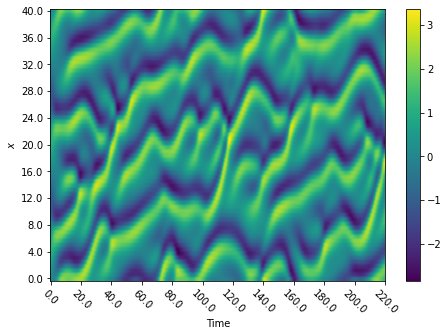

In [53]:
plot(
    boundary_idx_arr,
    delta_t,
    all_data,
    xgrid)

In [54]:
# making relevant helper arrays to cut off initial transient
num_cases = boundary_idx_arr.shape[0]

initial_t0 = np.array([
    20,
    # 20,
    # 20,
    # 20
])
initial_idx = np.zeros_like(initial_t0)

begin_idx = 0
len_relevant_idx = 0
for i in range(num_cases):
    init_idx = (initial_t0[i] + 0.5*delta_t)//delta_t
    initial_idx[i] = init_idx + begin_idx
    len_relevant_idx += boundary_idx_arr[i] - initial_idx[i]
    begin_idx = boundary_idx_arr[i]

relevant_idx = np.empty(shape=len_relevant_idx, dtype=np.int32)
start = 0
for i in range(num_cases):
    end = start + (boundary_idx_arr[i] - initial_idx[i])
    relevant_idx[start:end] = np.arange(initial_idx[i], boundary_idx_arr[i])
    start = end

In [55]:
# cutting off initial transient
all_data = all_data[relevant_idx]
# init_idx = 0
# for i in range(num_cases):
#     init_idx += (initial_t0[i] + 0.25*delta_t)//delta_t
#     boundary_idx_arr[i] -= init_idx

prev_boundary_idx = 0
for i in range(num_cases):
    boundary_idx_arr[i] = prev_boundary_idx + (boundary_idx_arr[i] - initial_idx[i])
    prev_boundary_idx = boundary_idx_arr[i]

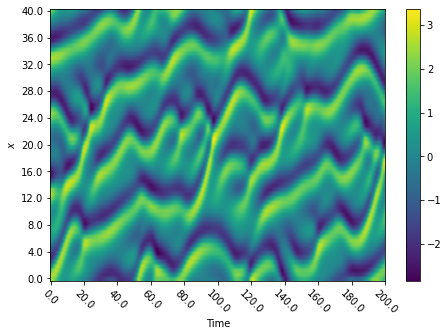

In [56]:
plot(
    boundary_idx_arr,
    delta_t,
    all_data,
    xgrid)

In [58]:
new_initial_states = np.empty(shape=(len(boundary_idx_arr), xgrid.shape[0]))

idx = 0
for i in range(num_cases):
    new_initial_states[i, :] = all_data[idx, :]
    idx = boundary_idx_arr[i]

In [59]:
res_dict = create_KS_data(
    T, t0, delta_t, xgrid,
    new_initial_states[i], params_mat[i],
    return_params_arr=return_params_arr,
    normalize=normalize_flag,
    alldata_withparams=alldata_withparams_flag,
)

all_data = res_dict['all_data']
N = res_dict['N']
boundary_idx_arr = res_dict['boundary_idx_arr']
params_arr = res_dict['params_arr']
normalization_constant_arr = res_dict['normalization_constant_arr']

In [174]:
def compute_lyapunov_spectrum(
        T, t0, delta_t, xgrid,
        init_state_mat, params_mat,
        return_params_arr=False,
        M_Cauchy=32, dy=1e-3, zeta=10):
    '''
    simulating the KS equation
    u_t = -nu1*u*u_x - nu2*u_xx - nu3*u_xxxx
    params_mat[0] = nu1
    params_mat[1] = nu2
    params_mat[2] = nu3
    '''

    if len(params_mat.shape) == 1:
        params_mat = params_mat.reshape((1, params_mat.shape[0]))
    N = int(((T-t0) + 0.5*delta_t) // delta_t)
    num_modes = xgrid.shape[0]
    num_params = params_mat.shape[1]
    num_cases = params_mat.shape[0]

    length = xgrid[-1]
    M = xgrid.shape[0]

    xi = int(N//zeta)
    print('xi:', xi)
    Rjj_mat = np.ones(shape=(xi, M))

    # scalars for ETDRK4
    h = delta_t
    k = fftfreq(M) * M * 2*np.pi/length

    lyap_coeffs = np.empty(shape=(num_cases, M))

    for ii in range(num_cases):
        init_state = init_state_mat[ii]
        dY = np.eye(M)*dy

        nu1 = params_mat[ii, 0]
        nu2 = params_mat[ii, 1]
        nu3 = params_mat[ii, 2]
        
        L = nu2*(k**2) - nu3*(k**4)
        E = np.exp(h*L)
        E_2 = np.exp(h*L/2)
        Q = 0
        phi1 = 0.0
        phi2 = 0.0
        phi3 = 0.0
    
        for j in range(1,M_Cauchy+1):
            arg = h*L + np.ones(L.shape[0]) * np.exp(2j*np.pi*(j-0.5)/M_Cauchy)
    
            phi1 += 1.0/arg * (np.exp(arg) - np.ones(L.shape[0]))
            phi2 += 1.0/arg**2 * (np.exp(arg) - arg - np.ones(L.shape[0]))
            phi3 += 1.0/arg**3 * (np.exp(arg) - 0.5*arg**2 - arg - np.ones(L.shape[0]))
            Q += 2.0/arg * (np.exp(0.5*arg) - np.ones(L.shape[0]))
    
        phi1 = np.real(phi1/M_Cauchy)
        phi2 = np.real(phi2/M_Cauchy)
        phi3 = np.real(phi3/M_Cauchy)
        Q = np.real(Q/M_Cauchy)
    
        f1 = phi1 - 3*phi2 + 4*phi3 #-4 - L * h + E * (4 - 3 * L * h + (L * h)*(L * h))
        f2 = 2*phi2 - 4*phi3 #2 + L * h + E * (-2 + L * h)
        f3 = -phi2 + 4*phi3 #-4 - 3 * L * h - (L*h)*(L*h) + E * (4 - L*h)
    
        # main loop
        v = fft(init_state)
        dYhat = fft(dY, axis=1)
        # print(dYhat.shape)
        
        for i in range(1, N+1):
            Nv = -nu1 * 0.5j * k * fft( np.real(ifft(v))**2 )
            a = E_2 * v + h/2 * Q * Nv
            Na = -nu1 * 0.5j * k * fft( np.real(ifft(a))**2 )
            b = E_2 * v + h/2 * Q * Na
            Nb = -nu1 * 0.5j * k * fft( np.real(ifft(b))**2 )
            c = E_2 * a + h/2 * Q * (2 * Nb - Nv)
            Nc = -nu1 * 0.5j * k * fft( np.real(ifft(c))**2 )

            for j in range(M):
                dyhat = dYhat[:, j]
                Nv_dyhat = -nu1 * 1j * k * fft( np.real(ifft(v))*np.real(ifft(dyhat)) )
                a_dyhat = E_2 * dyhat + h/2 * Q * Nv_dyhat
                Na_dyhat = -nu1 * 1j * k * fft( np.real(ifft(a))*np.real(ifft(a_dyhat)) )
                b_dyhat = E_2 * dyhat + h/2 * Q * Na_dyhat
                Nb_dyhat = -nu1 * 1j * k * fft( np.real(ifft(b))*np.real(ifft(b_dyhat)) )
                c_dyhat = E_2 * a_dyhat + h/2 * Q * (2 * Nb_dyhat - Nv_dyhat)
                Nc_dyhat = -nu1 * 1j * k * fft( np.real(ifft(c))*np.real(ifft(c_dyhat)) )
                # update dYhat[j, :]
                dYhat[:, j]= E * dyhat + h*f1*Nv_dyhat + h*f2*(Na_dyhat + Nb_dyhat) + h*f3*Nc_dyhat

            #update rule
            v = E * v + h*f1*Nv + h*f2*(Na+Nb) + h*f3*Nc

            if i % zeta == 0:
                Q_qrdecomp, R_qrdecomp = linalg.qr(np.real(ifft(dYhat)))
                dYhat = dy*fft(Q_qrdecomp, axis=1)
                for jj in range(M):
                    Rjj_mat[int(i//zeta)-1, jj] = R_qrdecomp[jj, jj]/dy
        
        for j in range(M):
            idx = np.where(Rjj_mat[:, j] > 0)[0]
            if idx.shape[0] < xi:
                print(j, idx.shape[0])
            lyap_coeffs[ii, j] = np.sum(np.log(Rjj_mat[:, j][idx])) / (zeta*idx.shape[0]*h)



    return lyap_coeffs, Rjj_mat

In [175]:
# %pdb
l, R = compute_lyapunov_spectrum(
    400, t0, delta_t, xgrid,
    new_initial_states, params_mat, dy=1e-6, zeta=100)

xi: 40
0 34
1 23
2 27
3 30
4 29
5 30
6 31
7 23
8 20
9 20
10 17
11 20
12 13
13 11
14 25
15 18
16 22
17 20
18 15
19 16
20 22
21 14
22 19
23 19
24 18
25 19
26 19
27 25
28 20
29 27
30 26
31 21
32 20
33 14
34 19
35 16
36 23
37 26
38 23
39 24
40 14
41 19
42 18
43 17
44 21
45 21
46 15
47 25
48 17
49 20
50 21
51 22
52 19
53 20
54 23
55 18
56 16
57 22
58 22
59 16
60 24
61 22
62 19
63 19


In [176]:
l.sort()

In [177]:
l

array([[-3.97804808, -3.88994843, -3.80287303, -3.7677775 , -3.73214934,
        -3.71663219, -3.69800552, -3.66623926, -3.59237742, -3.5018811 ,
        -3.24858766, -3.10008685, -2.77921212, -2.58016709, -2.36497518,
        -2.30052082, -2.14719677, -1.98101819, -1.95018825, -1.89463464,
        -1.78948769, -1.74056312, -1.60386008, -1.53326153, -1.51662606,
        -1.49824108, -1.49481522, -1.48814682, -1.43841117, -1.39234128,
        -1.27197068, -1.25890879, -1.22898728, -1.16570074, -1.10688331,
        -1.0752628 , -1.00242637, -0.90021601, -0.88536237, -0.76756484,
        -0.71344983, -0.60215509, -0.56075701, -0.49542232, -0.37148995,
        -0.31744314, -0.30956155, -0.19235016, -0.16980076, -0.1364797 ,
        -0.08561151, -0.06830306, -0.03860144, -0.03258085, -0.00499137,
         0.00495137,  0.030017  ,  0.06772561,  0.09975907,  0.10719113,
         0.13186816,  0.15432868,  0.15763657,  0.16304178]])

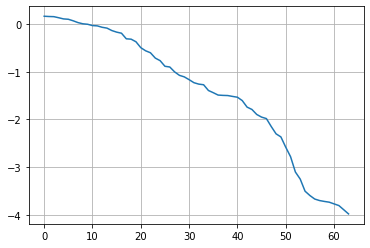

In [182]:
plt.plot(np.arange(l.shape[1]), l[0, -1::-1])
plt.grid(True)
plt.show()